# Init

In [1]:
# from skfem import *
import numpy as np
from utils import *
from skfem.helpers import d, dd, ddd, dot, ddot, grad, dddot, prod
from scipy.sparse.linalg import LinearOperator, minres
# from skfem.models.poisson import *
from skfem.assembly import BilinearForm, LinearForm
import datetime
import pandas as pd
from skfem.visuals.matplotlib import draw, plot
import sys
import time

tol = 1e-8
intorder = 5
solver_type = 'mgcg'
refine_time = 5
epsilon_range = 6
element_type = 'P1'
sigma = 5
penalty = False
# epsilon = 1e-5
example = 'ex4'
save_path = 'log/' + example + '_' + element_type + '_' + ('pen' if penalty else 'nopen') + '_' +'{}'.format(datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))

In [2]:
def dirichlet(w):
    """return a harmonic function"""
    global out
    x, y = w
    out = np.zeros_like(x)
    if x.ndim == 2:
        for i in range(x.shape[0]):
            for j in range(x.shape[1]):
                if x[i, j] != 0:
                    out[i, j] = (x[i, j]**2 + y[i, j]**2)**(5 / 6) * sin(5 * atan(y[i, j] / x[i, j]) / 3)
                elif y[i, j] > 0:
                    out[i, j] = (x[i, j]**2 + y[i, j]**2)**(5 / 6) * sin(90 * 5 / 3)
                else:
                    out[i, j] = (x[i, j]**2 + y[i, j]**2)**(5 / 6) * sin(270 * 5 / 3)
    elif x.ndim == 1:
        for i in range(x.shape[0]):
            if x[i] != 0:
                out[i] = (x[i]**2 + y[i]**2)**(5 / 6) * sin(5 * atan(y[i] / x[i]) / 3)
            elif y[i] > 0:
                out[i] = (x[i]**2 + y[i]**2)**(5 / 6) * sin(90 * 5 / 3)
            else:
                out[i] = (x[i]**2 + y[i]**2)**(5 / 6) * sin(270 * 5 / 3)
    else:
        raise Exception("dim not supported")
    return out

In [3]:
@LinearForm
def boundary_load_un(v, w):
    '''
    u_n * v
    '''
    global x, www, vvv
    vvv = v 
    www = w
    x, y = w.x
    u_x, u_y = dexact_u(x, y)
    return (w.n[0] * u_x + w.n[1] * u_y) * v

@LinearForm
def boundary_load_gradun(v, w):
    '''
    grad u_n * v
    '''
    x, y = w.x
    u_xx, u_xy, u_yx, u_yy = ddexact(x, y)
    return (u_xx * w.n[0] + u_xy * w.n[1]) * grad(v)[0] + (u_yx * w.n[0] + u_yy * w.n[1]) * grad(v)[1]

In [13]:
def solve_problem1(m, element_type='P1', solver_type='pcg', intorder=6, tol=1e-8, epsilon=1e-6):
    '''
    switching to mgcg solver for problem 1
    '''
    if element_type == 'P1':
        element = {'w': ElementTriP1(), 'u': ElementTriMorley()}
    elif element_type == 'P2':
        element = {'w': ElementTriP2(), 'u': ElementTriMorley()}
    else:
        raise Exception("Element not supported")

    basis = {
        variable: InteriorBasis(m, e, intorder=intorder)
        for variable, e in element.items()
    }
    
    K1 = asm(laplace, basis['w'])
    f1 = asm(f_load, basis['w'])
    wh = solve(*condense(K1, f1, D=basis['w'].find_dofs()), solver=solver_iter_mgcg(tol=tol))
    
    global K2, f2, uh0, boundary_dofs, boundary_basis
    fbasis = FacetBasis(m, ElementTriMorley())
    K2 = epsilon**2 * asm(a_load, basis['u']) + asm(b_load, basis['u'])
#     f2 = asm(wv_load, basis['w'], basis['u']) * wh + asm(boundary_load_un, fbasis) + epsilon**2 * asm(boundary_load_gradun, fbasis)
    f2 = asm(wv_load, basis['w'], basis['u']) * wh
#     boundary_basis = FacetBasis(m, element['w'])
    boundary_basis = FacetBasis(m, ElementTriMorley())
#     boundary_dofs = boundary_basis.find_dofs()
    boundary_dofs = boundary_basis.find_dofs()['all'].all()
#     boundary_dofs = basis['u'].nodal_dofs[0]
#     boundary_dofs = np.array([i for i in basis['u'].find_dofs()['all'].all() if i in basis['u'].nodal_dofs[0]])

#     boundary_dofs = basis['u'].facet_dofs[0]
#     boundary_dofs = m.boundary_nodes()
    uh0 = np.zeros(basis['u'].N)
#     print(boundary_dofs.shape[0])
#     print(basis['u'].N)
#     uh0[boundary_dofs] = pproject(dirichlet, basis_to=boundary_basis, I=boundary_dofs, solver=minres)
#     uh0[boundary_dofs] = exact_u(boundary_basis.doflocs[0][boundary_dofs], boundary_basis.doflocs[1][boundary_dofs])
    uh0[boundary_dofs] = exact_u(boundary_basis.doflocs[0][boundary_dofs], boundary_basis.doflocs[1][boundary_dofs])
    temp = uh0
#     print(exact_u(boundary_basis.doflocs[0][boundary_dofs], boundary_basis.doflocs[1][boundary_dofs]))
#     print(uh0)
#     uh0 = solve(*condense(K2, f2, D=easy_boundary(m, basis['u'])), solver=solver_iter_mgcg(tol=tol))
#     uh0 = solve(*condense(K2, f2, D=basis['u'].find_dofs()), solver=solver_iter_mgcg(tol=tol))
#     uh0 = solve(*condense(K2, f2, uh0, D=boundary_dofs), solver=solver_iter_krylov(minres, tol=tol))

    uh0 = solve(*condense(K2, f2, uh0, D=boundary_dofs), solver=solver_iter_mgcg(tol=tol))
#     uh0 = solve(*condense(K2, f2, uh0, D=basis['u'].find_dofs()), solver=solver_iter_mgcg(tol=tol))
#     print(uh0)
#     print(uh0-temp)
    return uh0, basis

# Solving

In [5]:
basis['u'].doflocs

NameError: name 'basis' is not defined

In [245]:
# basis['u'].nodal_dofs[0]
for i in range(25):
#     print(i)
#     print(boundary_basis.doflocs[:, i])
    pass

In [246]:
basis['u'].find_dofs()['all'].all()

array([ 0,  1,  2,  3,  4,  5,  7,  8,  9, 10, 11, 13, 14, 16, 17, 18],
      dtype=int64)

In [247]:
np.array([i for i in basis['u'].find_dofs()['all'].all() if i in basis['u'].nodal_dofs[0]])

array([0, 1, 2, 3, 4, 5, 7, 8], dtype=int64)

In [248]:
basis['u'].facet_dofs[0]

array([ 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24],
      dtype=int64)

In [249]:
uh0

array([-0.00000000e+00,  0.00000000e+00, -7.14876430e-01,  1.72108416e+00,
        0.00000000e+00, -2.25171965e-01,  2.83490655e-01,  8.40772452e-01,
        1.15929100e+00,  0.00000000e+00, -7.09247248e-02,  0.00000000e+00,
        2.61580998e-16,  4.17621992e-01, -4.42588118e-01, -6.93043928e-16,
        8.44349696e-01,  1.27411462e+00,  1.45003215e+00,  3.35263407e-16,
        2.30101007e-16,  2.37993136e-16, -1.04466823e-15,  1.15798174e-15,
        5.84082683e-16])

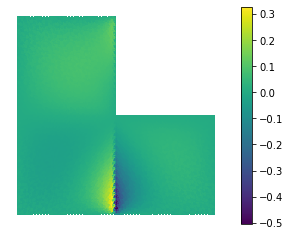

In [20]:
m = MeshTri().init_lshaped()
# m = MeshTri()
m.refine(5)
# draw(m)

epsilon = 0
ep = epsilon

uh0, basis = solve_problem1(m, element_type, solver_type, intorder, tol, epsilon)

x = basis['u'].doflocs[0]
y = basis['u'].doflocs[1]
u = exact_u(x, y)
plot(basis['u'], u-uh0, colorbar=True)

In [74]:
# v.value

In [73]:
# (w.n[0] * u_x + w.n[1] * u_y) * v

In [75]:
boundary_basis.find_dofs()['all'].all()

array([ 0,  1,  2,  3,  4,  5,  7,  8,  9, 10, 11, 13, 14, 16, 17, 18],
      dtype=int64)

In [71]:
basis['u'].nodal_dofs[0]

array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int64)

In [72]:
basis['u'].facet_dofs

array([[ 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]],
      dtype=int64)

In [ ]:
uh0.shape

boundary_dofs.shape

basis['u'].facet_dofs

basis['u'].nodal_dofs[0]

basis['u'].get_dofs()

basis['u'].find_dofs()['all'].all()

pproject(dirichlet, basis_to=boundary_basis, I=boundary_dofs, solver=minres)

exact_u(boundary_basis.doflocs[0][boundary_dofs], boundary_basis.doflocs[1][boundary_dofs])

boundary_dofs

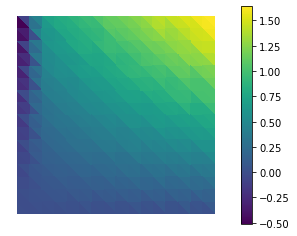

In [16]:
plot(basis['u'], u, colorbar=True)

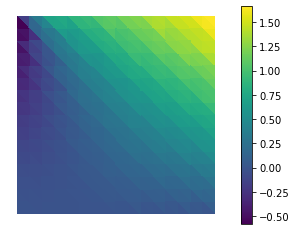

In [17]:
plot(basis['u'], uh0, colorbar=True)

In [65]:
# w = www
# v = vvv
# x, y = w.x
# u_x, u_y = dexact_u(x, y)
# (w.n[0] * u_x + w.n[1] * u_y) * v

In [ ]:
exact_u(x, y)

In [ ]:
dirichlet([x, y])

In [ ]:
exact_u(np.array([-0.00000]), np.array([0.8]))

In [ ]:
dirichlet([np.array([[-0.00000]]), np.array([[0.8]])])

In [ ]:
boundary_basis.mesh

In [ ]:
exact_u(boundary_basis.doflocs[0], boundary_basis.doflocs[1])

In [ ]:
pproject(dirichlet, basis_to=boundary_basis, I=boundary_dofs, solver=minres)

In [ ]:
(uh0 - u)[:30]

In [ ]:
u

In [256]:
time_start = time.time()

print('=======Arguments=======')
print('penalty:\t{}'.format(penalty))
print('element_type:\t{}'.format(element_type))
print('solver_type:\t{}'.format(solver_type))
print('tol:\t{}'.format(tol))
print('intorder:\t{}'.format(intorder))
print('refine_time:\t{}'.format(refine_time))
print('sigma:\t{}'.format(sigma))
print('=======Results=======')

df_list = []
for j in range(epsilon_range):
    epsilon = 1 * 10**(-j)
    ep = epsilon
    L2_list = []
    Du_list = []
    D2u_list = []
    h_list = []
    epu_list = []
    m = MeshTri().init_lshaped()
#     m = MeshTri()
#     draw(m)

    for i in range(1, refine_time+1):
        
        m.refine()
        
        if penalty:
            uh0, basis, fbasis = solve_problem2(m, element_type, solver_type, intorder, tol, epsilon)
        else:
            uh0, basis = solve_problem1(m, element_type, solver_type, intorder, tol, epsilon)

        U = basis['u'].interpolate(uh0).value

        # compute errors

        L2u = np.sqrt(L2uError.assemble(basis['u'], w=U))
        Du = get_DuError(basis['u'], uh0)
        H1u = Du + L2u
        if penalty:
            D2u = np.sqrt(get_D2uError(basis['u'], uh0)**2 + L2pnvError.assemble(fbasis, w=fbasis.interpolate(uh0)))
        else:
            D2u = get_D2uError(basis['u'], uh0)
        epu = np.sqrt(epsilon**2 * D2u**2 + Du**2)
        h_list.append(m.param())
        Du_list.append(Du)
        L2_list.append(L2u)
        D2u_list.append(D2u)
        epu_list.append(epu)
        
    hs = np.array(h_list)
    L2s = np.array(L2_list)
    Dus = np.array(Du_list)
    D2us = np.array(D2u_list)
    epus = np.array(epu_list)
    H1s = L2s + Dus
    H2s = H1s + D2us
    
    # store data
    data = np.array([L2s, H1s, H2s, epus])
    df = pd.DataFrame(data.T, columns=['L2', 'H1', 'H2', 'Energy'])
    df_list.append(df)
    
    print('epsilion:', epsilon)
    show_result(L2s, H1s, H2s, epus)

time_end = time.time()

result = df_list[0].append(df_list[1:])
result.to_csv(save_path+'.csv')
print('======= Errors saved in:', save_path+'.csv ==========')
print('Total Time Cost {:.2f} s'.format(time_end-time_start))

=======Arguments=======
penalty:	False
element_type:	P1
solver_type:	mgcg
tol:	1e-08
intorder:	5
refine_time:	5
sigma:	5
=======Results=======
32
65
[-0.          0.         -0.71487643 -0.         -0.68328373  1.72108416
 -1.72108416 -1.72108416  0.         -0.22517197 -0.84077245 -1.159291
  0.84077245 -0.84077245  1.159291   -1.159291    0.         -0.07092472
  0.         -0.41762199 -0.44258812 -0.8443497   0.41762199 -0.41762199
  0.8443497  -0.8443497   1.27411462  1.45003215 -1.45003215 -1.27411462
 -1.27411462 -1.45003215]
[-0.          0.         -0.71487643 -0.         -0.68328373  1.72108416
 -1.72108416 -1.72108416  0.         -0.22517197  0.          0.
  0.          0.          0.         -0.84077245 -1.159291    0.84077245
 -0.84077245  1.159291   -1.159291    0.         -0.07092472  0.
  0.          0.          0.          0.          0.         -0.41762199
 -0.44258812 -0.8443497   0.          0.41762199 -0.41762199  0.
  0.8443497  -0.8443497   0.          1.27411462

[-0.          0.         -0.71487643 -0.         -0.68328373  1.72108416
 -1.72108416 -1.72108416  0.         -0.22517197 -0.84077245 -1.159291
  0.84077245 -0.84077245  1.159291   -1.159291    0.         -0.07092472
  0.         -0.41762199 -0.44258812 -0.8443497   0.41762199 -0.41762199
  0.8443497  -0.8443497   1.27411462  1.45003215 -1.45003215 -1.27411462
 -1.27411462 -1.45003215  0.         -0.02233989  0.         -0.20845361
 -0.57223937 -0.67618834  0.20845361 -0.20845361  0.67618834 -0.67618834
  1.4957281   1.58777283 -1.58777283 -1.4957281  -1.4957281  -1.58777283
  0.          0.         -0.13940652 -0.32661115 -0.62818723 -1.05592577
 -1.00516004 -1.30738386  0.62818723  1.05592577 -0.62818723 -1.05592577
  1.00516004  1.30738386 -1.00516004 -1.30738386  0.         -0.00703662
  0.         -0.10418173 -0.64197252 -0.58913911  0.10418173 -0.10418173
  0.58913911 -0.58913911  1.60792096  1.65495452 -1.65495452 -1.60792096
 -1.60792096 -1.65495452  0.          0.         -0.1

256
3201
[-0.          0.         -0.71487643 -0.         -0.68328373  1.72108416
 -1.72108416 -1.72108416  0.         -0.22517197 -0.84077245 -1.159291
  0.84077245 -0.84077245  1.159291   -1.159291    0.         -0.07092472
  0.         -0.41762199 -0.44258812 -0.8443497   0.41762199 -0.41762199
  0.8443497  -0.8443497   1.27411462  1.45003215 -1.45003215 -1.27411462
 -1.27411462 -1.45003215  0.         -0.02233989  0.         -0.20845361
 -0.57223937 -0.67618834  0.20845361 -0.20845361  0.67618834 -0.67618834
  1.4957281   1.58777283 -1.58777283 -1.4957281  -1.4957281  -1.58777283
  0.          0.         -0.13940652 -0.32661115 -0.62818723 -1.05592577
 -1.00516004 -1.30738386  0.62818723  1.05592577 -0.62818723 -1.05592577
  1.00516004  1.30738386 -1.00516004 -1.30738386  0.         -0.00703662
  0.         -0.10418173 -0.64197252 -0.58913911  0.10418173 -0.10418173
  0.58913911 -0.58913911  1.60792096  1.65495452 -1.65495452 -1.60792096
 -1.60792096 -1.65495452  0.          0.    

[-0.          0.         -0.71487643 ...  1.35180526  0.00190884
 -1.28996734]
[ 0.          0.          0.         ...  1.35180526  0.00190884
 -1.28996734]
epsilion: 1
  h    L2u   H1u   H2u   epu
2^-2  0.76  -0.01  -0.34  -0.43
2^-2  2.096e-01  3.999e+00  1.644e+01  1.300e+01
2^-3  0.34  0.00  -0.46  -0.55
2^-3  1.661e-01  3.992e+00  2.261e+01  1.900e+01
2^-4  0.11  -0.01  -0.63  -0.72
2^-4  1.537e-01  4.006e+00  3.497e+01  3.120e+01
2^-5  0.03  -0.02  -0.79  -0.86
2^-5  1.502e-01  4.054e+00  6.062e+01  5.670e+01
32
65
[-0.          0.         -0.71487643 -0.         -0.68328373  1.72108416
 -1.72108416 -1.72108416  0.         -0.22517197 -0.84077245 -1.159291
  0.84077245 -0.84077245  1.159291   -1.159291    0.         -0.07092472
  0.         -0.41762199 -0.44258812 -0.8443497   0.41762199 -0.41762199
  0.8443497  -0.8443497   1.27411462  1.45003215 -1.45003215 -1.27411462
 -1.27411462 -1.45003215]
[-0.          0.         -0.71487643 -0.         -0.68328373  1.72108416
 -1.721084

256
3201
[-0.          0.         -0.71487643 -0.         -0.68328373  1.72108416
 -1.72108416 -1.72108416  0.         -0.22517197 -0.84077245 -1.159291
  0.84077245 -0.84077245  1.159291   -1.159291    0.         -0.07092472
  0.         -0.41762199 -0.44258812 -0.8443497   0.41762199 -0.41762199
  0.8443497  -0.8443497   1.27411462  1.45003215 -1.45003215 -1.27411462
 -1.27411462 -1.45003215  0.         -0.02233989  0.         -0.20845361
 -0.57223937 -0.67618834  0.20845361 -0.20845361  0.67618834 -0.67618834
  1.4957281   1.58777283 -1.58777283 -1.4957281  -1.4957281  -1.58777283
  0.          0.         -0.13940652 -0.32661115 -0.62818723 -1.05592577
 -1.00516004 -1.30738386  0.62818723  1.05592577 -0.62818723 -1.05592577
  1.00516004  1.30738386 -1.00516004 -1.30738386  0.         -0.00703662
  0.         -0.10418173 -0.64197252 -0.58913911  0.10418173 -0.10418173
  0.58913911 -0.58913911  1.60792096  1.65495452 -1.65495452 -1.60792096
 -1.60792096 -1.65495452  0.          0.    

epsilion: 0.1
  h    L2u   H1u   H2u   epu
2^-2  0.84  -0.02  -0.33  -0.12
2^-2  1.820e-01  3.671e+00  1.856e+01  3.794e+00
2^-3  0.52  -0.04  -0.35  -0.13
2^-3  1.268e-01  3.764e+00  2.373e+01  4.149e+00
2^-4  0.20  -0.03  -0.57  -0.24
2^-4  1.100e-01  3.852e+00  3.531e+01  4.889e+00
2^-5  0.07  -0.03  -0.78  -0.49
2^-5  1.052e-01  3.928e+00  6.069e+01  6.843e+00
32
65
[-0.          0.         -0.71487643 -0.         -0.68328373  1.72108416
 -1.72108416 -1.72108416  0.         -0.22517197 -0.84077245 -1.159291
  0.84077245 -0.84077245  1.159291   -1.159291    0.         -0.07092472
  0.         -0.41762199 -0.44258812 -0.8443497   0.41762199 -0.41762199
  0.8443497  -0.8443497   1.27411462  1.45003215 -1.45003215 -1.27411462
 -1.27411462 -1.45003215]
[-0.          0.         -0.71487643 -0.         -0.68328373  1.72108416
 -1.72108416 -1.72108416  0.         -0.22517197  0.          0.
  0.          0.          0.         -0.84077245 -1.159291    0.84077245
 -0.84077245  1.159291   -1

[-0.          0.         -0.71487643 -0.         -0.68328373  1.72108416
 -1.72108416 -1.72108416  0.         -0.22517197  0.          0.
  0.          0.          0.         -0.84077245 -1.159291    0.84077245
 -0.84077245  1.159291   -1.159291    0.         -0.07092472  0.
  0.          0.          0.          0.          0.         -0.41762199
 -0.44258812 -0.8443497   0.          0.41762199 -0.41762199  0.
  0.8443497  -0.8443497   0.          1.27411462  1.45003215  0.
 -1.45003215 -1.27411462  0.         -1.27411462 -1.45003215  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
 -0.02233989  0.          0.          0.          0.          0.
  0.         -0.20845361 -0.57223937 -0.67618834  0.          0.20845361
 -0.20845361  0.          0.67618834 -0.67618834  0.          1.4957281
  1.58777283  0.         -1.58777283 -1.4957281   0

256
3201
[-0.          0.         -0.71487643 -0.         -0.68328373  1.72108416
 -1.72108416 -1.72108416  0.         -0.22517197 -0.84077245 -1.159291
  0.84077245 -0.84077245  1.159291   -1.159291    0.         -0.07092472
  0.         -0.41762199 -0.44258812 -0.8443497   0.41762199 -0.41762199
  0.8443497  -0.8443497   1.27411462  1.45003215 -1.45003215 -1.27411462
 -1.27411462 -1.45003215  0.         -0.02233989  0.         -0.20845361
 -0.57223937 -0.67618834  0.20845361 -0.20845361  0.67618834 -0.67618834
  1.4957281   1.58777283 -1.58777283 -1.4957281  -1.4957281  -1.58777283
  0.          0.         -0.13940652 -0.32661115 -0.62818723 -1.05592577
 -1.00516004 -1.30738386  0.62818723  1.05592577 -0.62818723 -1.05592577
  1.00516004  1.30738386 -1.00516004 -1.30738386  0.         -0.00703662
  0.         -0.10418173 -0.64197252 -0.58913911  0.10418173 -0.10418173
  0.58913911 -0.58913911  1.60792096  1.65495452 -1.65495452 -1.60792096
 -1.60792096 -1.65495452  0.          0.    

epsilion: 0.01
  h    L2u   H1u   H2u   epu
2^-2  0.84  0.03  -0.72  -0.04
2^-2  1.834e-01  3.504e+00  2.724e+01  3.329e+00
2^-3  0.52  0.03  -0.81  0.00
2^-3  1.282e-01  3.427e+00  4.780e+01  3.329e+00
2^-4  0.23  -0.00  -0.73  -0.03
2^-4  1.095e-01  3.433e+00  7.907e+01  3.408e+00
2^-5  0.08  -0.05  -0.45  -0.08
2^-5  1.033e-01  3.556e+00  1.078e+02  3.607e+00
32
65
[-0.          0.         -0.71487643 -0.         -0.68328373  1.72108416
 -1.72108416 -1.72108416  0.         -0.22517197 -0.84077245 -1.159291
  0.84077245 -0.84077245  1.159291   -1.159291    0.         -0.07092472
  0.         -0.41762199 -0.44258812 -0.8443497   0.41762199 -0.41762199
  0.8443497  -0.8443497   1.27411462  1.45003215 -1.45003215 -1.27411462
 -1.27411462 -1.45003215]
[-0.          0.         -0.71487643 -0.         -0.68328373  1.72108416
 -1.72108416 -1.72108416  0.         -0.22517197  0.          0.
  0.          0.          0.         -0.84077245 -1.159291    0.84077245
 -0.84077245  1.159291   -1.1

128
833
[-0.          0.         -0.71487643 -0.         -0.68328373  1.72108416
 -1.72108416 -1.72108416  0.         -0.22517197 -0.84077245 -1.159291
  0.84077245 -0.84077245  1.159291   -1.159291    0.         -0.07092472
  0.         -0.41762199 -0.44258812 -0.8443497   0.41762199 -0.41762199
  0.8443497  -0.8443497   1.27411462  1.45003215 -1.45003215 -1.27411462
 -1.27411462 -1.45003215  0.         -0.02233989  0.         -0.20845361
 -0.57223937 -0.67618834  0.20845361 -0.20845361  0.67618834 -0.67618834
  1.4957281   1.58777283 -1.58777283 -1.4957281  -1.4957281  -1.58777283
  0.          0.         -0.13940652 -0.32661115 -0.62818723 -1.05592577
 -1.00516004 -1.30738386  0.62818723  1.05592577 -0.62818723 -1.05592577
  1.00516004  1.30738386 -1.00516004 -1.30738386  0.         -0.00703662
  0.         -0.10418173 -0.64197252 -0.58913911  0.10418173 -0.10418173
  0.58913911 -0.58913911  1.60792096  1.65495452 -1.65495452 -1.60792096
 -1.60792096 -1.65495452  0.          0.     

256
3201
[-0.          0.         -0.71487643 -0.         -0.68328373  1.72108416
 -1.72108416 -1.72108416  0.         -0.22517197 -0.84077245 -1.159291
  0.84077245 -0.84077245  1.159291   -1.159291    0.         -0.07092472
  0.         -0.41762199 -0.44258812 -0.8443497   0.41762199 -0.41762199
  0.8443497  -0.8443497   1.27411462  1.45003215 -1.45003215 -1.27411462
 -1.27411462 -1.45003215  0.         -0.02233989  0.         -0.20845361
 -0.57223937 -0.67618834  0.20845361 -0.20845361  0.67618834 -0.67618834
  1.4957281   1.58777283 -1.58777283 -1.4957281  -1.4957281  -1.58777283
  0.          0.         -0.13940652 -0.32661115 -0.62818723 -1.05592577
 -1.00516004 -1.30738386  0.62818723  1.05592577 -0.62818723 -1.05592577
  1.00516004  1.30738386 -1.00516004 -1.30738386  0.         -0.00703662
  0.         -0.10418173 -0.64197252 -0.58913911  0.10418173 -0.10418173
  0.58913911 -0.58913911  1.60792096  1.65495452 -1.65495452 -1.60792096
 -1.60792096 -1.65495452  0.          0.    

KeyboardInterrupt: 